<a href="https://colab.research.google.com/github/mananjain02/FoodVision/blob/main/ultimate_food_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.4.1

# Importing the libraries
* pandas, numpy, matplotlib, seaborn and tf

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Helper function

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-07-17 13:03:17--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.3’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-07-17 13:03:17 (102 MB/s) - ‘helper_functions.py.3’ saved [10246/10246]



In [ ]:
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

# Importing data from tensorflow dataset

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
(train_data, test_data), data_info = tfds.load(name='food101',
                                               split=['train', "validation"],
                                               shuffle_files=True,
                                               as_supervised=True,
                                               with_info=True)

## Defining class_names

In [ ]:
class_names = data_info.features['label'].names

# Visualizing the data

Image shape(512, 512, 3)


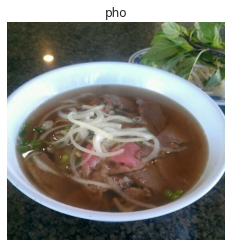

In [ ]:
for image, label in train_data.take(1):
    print(f"Image shape{image.shape}")
    plt.imshow(image)
    plt.axis('off')
    plt.title(class_names[label.numpy()])

# Function to preprocess image

In [ ]:
import tensorflow as tf
def image_preprocessing(image, label, img_size=224):
    image = tf.image.resize(image, (img_size, img_size))
    return tf.cast(image, dtype=tf.float32), label

In [ ]:
image = image_preprocessing(image, label)

Text(0.5, 1.0, '(224, 224, 3) pho')

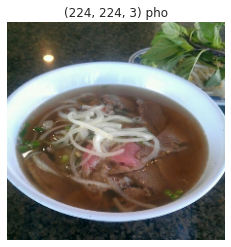

In [ ]:
plt.imshow(image[0]/255.)
plt.axis('off')
plt.title(str(image[0].shape) + " " + str(class_names[label]))

# Batching and preparing datasets

In [ ]:
# applying image_preprocessing function to all images in train data and tf.data.AUTOTUNE makes use of all gpu and cpu available
train_data = train_data.map(image_preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# doing the same for the test data
test_data = test_data.map(image_preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

# Creating checkpoints

In [ ]:
checkpoint_path = 'checkpoints/model_0.ckpt'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                         monitor='val_accuracy',
                                                         save_best_only=True)

In [ ]:
Early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=3)

In [ ]:
import tensorflow as tf
tf.__version__

'2.4.1'

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

# Creating model

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.losses import SparseCategoricalCrossentropy

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.Input(shape=(224,224,3))
x = base_model(inputs)
x = tf.keras.layers.GlobalAvgPool2D()(x)
x = tf.keras.layers.Dense(len(class_names))(x)
outputs = tf.keras.layers.Activation('softmax', dtype=tf.float32)(x)

model_0 = tf.keras.Model(inputs, outputs)

model_0.compile(loss='SparseCategoricalCrossentropy', metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam())

In [ ]:
model_0.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1280)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 101)               129381    
_________________________________________________________________
activation_3 (Activation)    (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
history_model_0 = model_0.fit(train_data,
          epochs=3,
          validation_data=test_data,
          steps_per_epoch=len(train_data),
          validation_steps=int(.2*len(test_data)),
          callbacks=[create_tensorboard_callback(dir_name='tensorboard',
                                                 experiment_name='model_0'),
                     checkpoint_callback])

Saving TensorBoard log files to: tensorboard/model_0/20210717-130330
Epoch 1/3
2368/2368 [==============================] - 190s 76ms/step - loss: 2.3855 - accuracy: 0.4504 - val_loss: 1.2540 - val_accuracy: 0.6679
INFO:tensorflow:Assets written to: checkpoints/model_0.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/model_0.ckpt/assets


Epoch 2/3
2368/2368 [==============================] - 175s 73ms/step - loss: 1.3929 - accuracy: 0.6424 - val_loss: 1.1466 - val_accuracy: 0.6942
INFO:tensorflow:Assets written to: checkpoints/model_0.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/model_0.ckpt/assets


Epoch 3/3
2368/2368 [==============================] - 175s 73ms/step - loss: 1.2295 - accuracy: 0.6811 - val_loss: 1.0985 - val_accuracy: 0.7051
INFO:tensorflow:Assets written to: checkpoints/model_0.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/model_0.ckpt/assets


In [ ]:
model_evaluate = model_0.evaluate(test_data)

790/790 [==============================] - 58s 71ms/step - loss: 1.0819 - accuracy: 0.7087


In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-5]:
    layer.trainable = False

model_0.compile(loss='SparseCategoricalCrossentropy', metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam(learning_rate=.0001))

In [ ]:
history_model_0_finetuned = model_0.fit(train_data,
                                        epochs=3,
                                        validation_data=test_data,
                                        steps_per_epoch=len(train_data),
                                        validation_steps=int(.2*len(test_data)),
                                        callbacks=[create_tensorboard_callback(dir_name='tensorboard',
                                                                                experiment_name='model_0_finetuned')])

Saving TensorBoard log files to: tensorboard/model_0_finetuned/20210717-132643
Epoch 1/3
2368/2368 [==============================] - 200s 81ms/step - loss: 0.8297 - accuracy: 0.7810 - val_loss: 0.9089 - val_accuracy: 0.7464
Epoch 2/3
2368/2368 [==============================] - 201s 82ms/step - loss: 0.7727 - accuracy: 0.7968 - val_loss: 0.9097 - val_accuracy: 0.7464
Epoch 3/3
2368/2368 [==============================] - 202s 82ms/step - loss: 0.7273 - accuracy: 0.8099 - val_loss: 0.9005 - val_accuracy: 0.7490


In [ ]:
model_evaluate_finetuned = model_0.evaluate(test_data)

790/790 [==============================] - 60s 74ms/step - loss: 0.8978 - accuracy: 0.7524


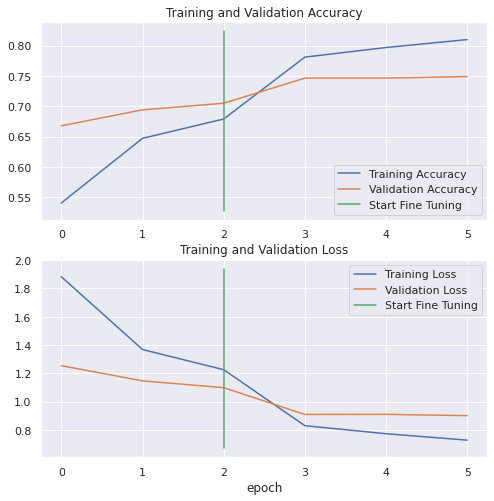

In [ ]:
compare_historys(history_model_0, history_model_0_finetuned, 3)

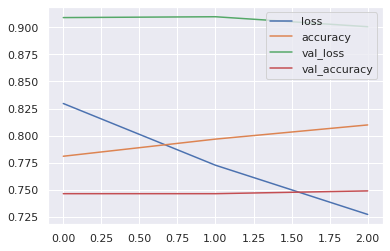

In [ ]:
pd.DataFrame(history_model_0_finetuned.history).plot()

In [ ]:
model_0.save('/content/drive/MyDrive/tensorflow_models/food_101_75_accurate')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow_models/food_101_75_accurate/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow_models/food_101_75_accurate/assets
